In [1]:
from numpy.random import seed
seed(8) #1

import logging

import tensorflow as tf
tf.random.set_seed(7)

import numpy as np
import pandas as pd

import os

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

2023-12-12 11:50:10.248259: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2023-12-12 11:50:17.041568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 11:50:17.091921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 11:50:17.091968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from os import listdir

data_list = listdir('covid-19/four_classes/train')
print(len(data_list))

4


In [4]:
DATASET_PATH  = 'covid-19/combined_folds'
test_dir =  'covid-19/four_classes/test'
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_SIZE    = (IMAGE_HEIGHT, IMAGE_WIDTH)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 8
NUM_EPOCHS    = 20
LEARNING_RATE = 0.0001
SEED = 42

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

Found 1132 images belonging to 4 classes.
Found 282 images belonging to 4 classes.


In [6]:
import tensorflow.keras
import keras.backend as K
from tensorflow.keras.layers import AveragePooling2D, Permute, Lambda, multiply
from tensorflow.keras.layers import Conv1D, Conv2D, BatchNormalization, ReLU

class CoordAtt(tf.keras.Model):
    def __init__(self, inputChannel, outputChannel, reductionRatio=32):
        super(CoordAtt, self).__init__()
        
        reductionChannel = max(8, inputChannel//reductionRatio)
        
        self.conv1 = Conv2D(filters=reductionChannel,
                            kernel_size=1,
                            strides=1,
                            padding="valid")
        
        self.conv_h = Conv2D(filters=outputChannel,
                             kernel_size=1,
                             strides=1,
                             padding="valid",
                             activation="sigmoid")
        self.conv_w = Conv2D(filters=outputChannel,
                             kernel_size=1,
                             strides=1,
                             padding="valid",
                             activation="sigmoid")
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act = ReLU(6., name="ReLU6_1")
        
    def build(self, input_shape):
        [n, h, w, c] = input_shape
        
        self.n = n
        self.h = h
        self.w = w
        self.c = c
        
        self.avg_h = AveragePooling2D(pool_size=(h, 1),
                                    strides=1,
                                    padding='valid',
                                    data_format="channels_last")
        self.avg_w = AveragePooling2D(pool_size=(1, w),
                                    strides=1, padding='valid',
                                    data_format="channels_last")
        

    def call(self, input_tensor):
        identity = tf.identity(input_tensor)
        
        x_h = self.avg_h(input_tensor)

        x_w = self.avg_w(input_tensor)
        x_w = Permute((2, 1, 3))(x_w)

        y = K.concatenate((x_h, x_w), axis=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act((y+3)/6)
        
        x_h, x_w = Lambda(tf.split, arguments={"axis":2, "num_or_size_splits":[self.w, self.h]})(y)
        x_w = Permute((2, 1, 3))(x_w)
        
        a_h = self.conv_h(x_h)
        a_w = self.conv_w(x_w)
        
        a_h = tf.tile(a_h, [1, self.h, 1, 1])
        a_w = tf.tile(a_w, [1, 1, self.w, 1])
        
        out = multiply([identity, a_w, a_h])
        return out

In [14]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

conv_base.trainable = True

model = models.Sequential()
model.add(conv_base)
model.add(CoordAtt(2048,2048))
model.add(layers.Reshape((49, 2048)))
model.add(layers.LSTM(512))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

adam_optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['acc'])

In [15]:
model.build((BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

In [16]:
#model=load_model('rovovk-CoroNet.keras')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 coord_att_2 (CoordAtt)      (None, 7, 7, 2048)        397632    
                                                                 
 reshape_2 (Reshape)         (None, 49, 2048)          0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               5244928   
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)              

In [17]:
print(len(train_batches))
print(len(valid_batches))

142
36


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    start_from_epoch=3,
    verbose=1
)

In [ ]:
result = model.fit(
    train_batches,
    validation_data = valid_batches,
    epochs= NUM_EPOCHS,
    callbacks=[earlystopping])

Epoch 1/20


2023-11-22 18:18:05.894156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-11-22 18:18:06.548219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-22 18:18:06.565646: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2c1e5dbaa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 18:18:06.565679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-11-22 18:18:06.569224: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-22 18:18:06.650108: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

142/142 [==============================] - 34s 121ms/step - loss: 1.0160 - acc: 0.5239 - val_loss: 0.8480 - val_acc: 0.5993
Epoch 2/20
142/142 [==============================] - 14s 101ms/step - loss: 0.7182 - acc: 0.6935 - val_loss: 0.6546 - val_acc: 0.7163
Epoch 3/20
142/142 [==============================] - 14s 101ms/step - loss: 0.5906 - acc: 0.7694 - val_loss: 0.5164 - val_acc: 0.8085
Epoch 4/20
142/142 [==============================] - 15s 106ms/step - loss: 0.5056 - acc: 0.8198 - val_loss: 0.4446 - val_acc: 0.8440
Epoch 5/20
142/142 [==============================] - 15s 103ms/step - loss: 0.4890 - acc: 0.8357 - val_loss: 0.4385 - val_acc: 0.8688
Epoch 6/20
142/142 [==============================] - 15s 102ms/step - loss: 0.4602 - acc: 0.8383 - val_loss: 0.3545 - val_acc: 0.8688
Epoch 7/20
142/142 [==============================] - 14s 101ms/step - loss: 0.4100 - acc: 0.8542 - val_loss: 0.3781 - val_acc: 0.8617
Epoch 8/20
142/142 [==============================] - 14s 101ms/st

In [13]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.savefig("Loss.png")
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig("Accuracy.png")
    plt.show()

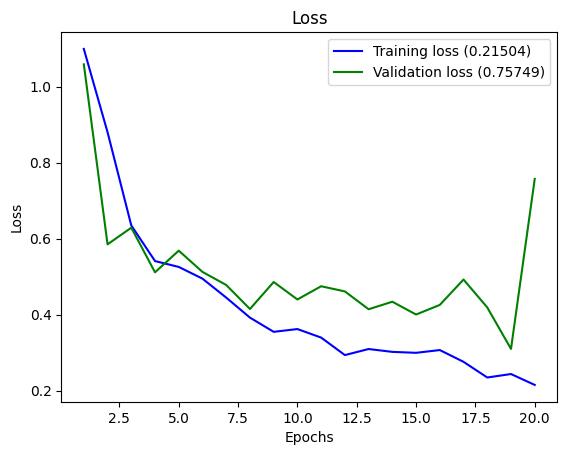

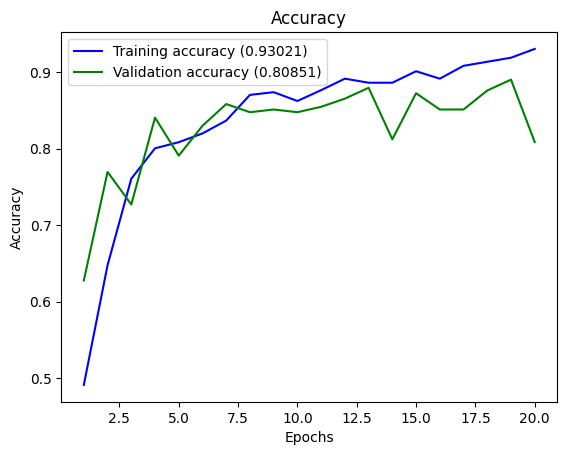

In [14]:
plot_history(result)

In [15]:
#model.save('rovovk-CoroNet.keras')

In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  'covid-19/combined_folds'
eval_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=10,
                                                  shuffle=False,
                                                  classes=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"],
                                                  seed=42,
                                                  class_mode="categorical")
eval_generator.reset()

Found 1414 images belonging to 4 classes.


In [17]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

/tmp/ipykernel_23124/3552618868.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,


142/142 [==============================] - 9s 62ms/step - loss: 0.3509 - acc: 0.9003
Test loss: 0.35090962052345276
Test accuracy: 0.9002828598022461


In [15]:
from sklearn.metrics import classification_report

filenames = eval_generator.filenames
eval_generator.reset()  
predict = model.predict(eval_generator,steps = np.ceil(len(eval_generator)))
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)

142/142 [==============================] - 8s 56ms/step


In [16]:
names=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"]

In [17]:
print(classification_report(
    y_true = classes,
    y_pred = predict,
    target_names = names
))

                     precision    recall  f1-score   support

              covid       0.70      0.98      0.82       305
             normal       0.84      0.95      0.89       375
pneumonia_bacterial       0.96      0.48      0.64       380
    pneumonia_viral       0.59      0.62      0.61       354

           accuracy                           0.75      1414
          macro avg       0.77      0.76      0.74      1414
       weighted avg       0.78      0.75      0.74      1414



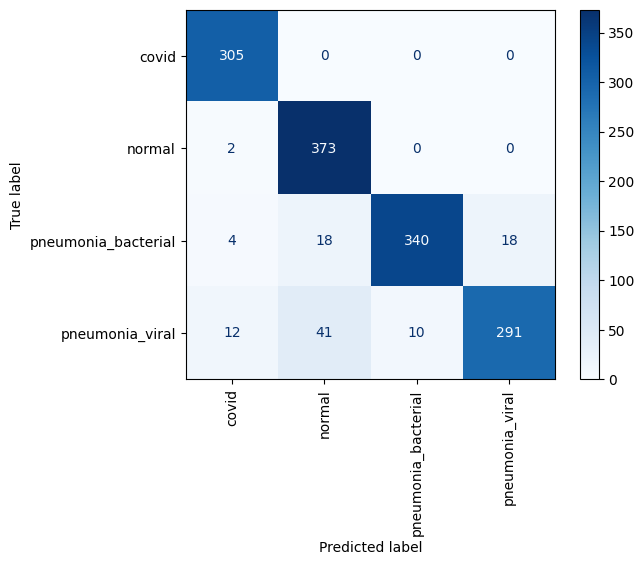

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_predictions(
    y_true = classes,
    y_pred = predict,
    display_labels = names,
    xticks_rotation = "vertical",
    cmap = plt.cm.Blues
)

In [22]:
#cm.figure_.savefig("confusion_matrix_full.png")

In [23]:
def evaluate_fold(fold_number):
    fold_test_datagen = ImageDataGenerator(rescale=1. / 255)
    fold_test_dir =  'covid-19/covid_folds/Fold' + str(fold_number)
    fold_eval_generator = test_datagen.flow_from_directory(fold_test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=10,
                                                  shuffle=False,
                                                  classes=["covid", "normal", "pneumonia_bacterial", "pneumonia_viral"],
                                                  seed=42,
                                                  class_mode="categorical")
    fold_eval_generator.reset()
    x = model.evaluate(fold_eval_generator,
                           steps = np.ceil(len(fold_eval_generator)), 
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1,
                           )
    
    fold_filenames = fold_eval_generator.filenames
    
    fold_predict = model.predict(fold_eval_generator,steps = np.ceil(len(fold_eval_generator)))
    fold_predict = np.argmax(fold_predict, axis=-1)
    fold_classes = fold_eval_generator.classes[fold_eval_generator.index_array]
                                               
    return ConfusionMatrixDisplay.from_predictions(
        y_true = fold_classes,
        y_pred = fold_predict,
        display_labels = names,
        xticks_rotation = "vertical",
        cmap = plt.cm.Blues
    )

Found 277 images belonging to 4 classes.
 1/28 [>.............................] - ETA: 2s - loss: 0.0269 - acc: 1.0000

/tmp/ipykernel_3255/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


28/28 [==============================] - 2s 55ms/step
Found 277 images belonging to 4 classes.
 1/28 [>.............................] - ETA: 2s - loss: 0.0266 - acc: 1.0000

/tmp/ipykernel_3255/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


28/28 [==============================] - 2s 53ms/step
Found 284 images belonging to 4 classes.


/tmp/ipykernel_3255/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


29/29 [==============================] - 2s 53ms/step
Found 281 images belonging to 4 classes.


/tmp/ipykernel_3255/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


29/29 [==============================] - 1s 39ms/step
Found 293 images belonging to 4 classes.


/tmp/ipykernel_3255/379387111.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(fold_eval_generator,


30/30 [==============================] - 2s 53ms/step


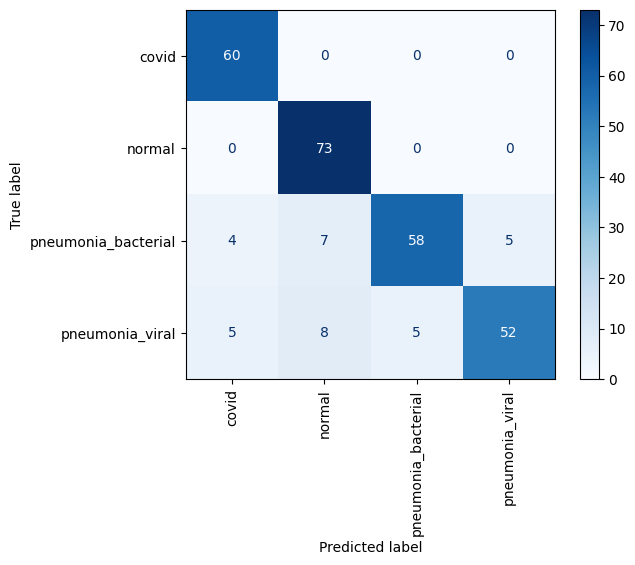

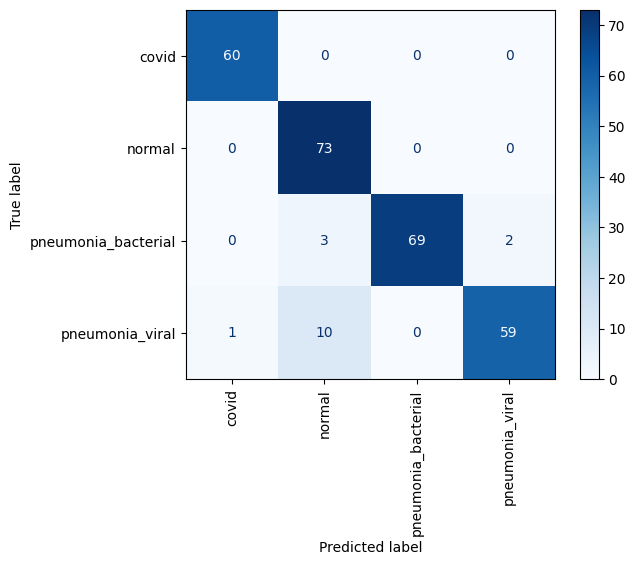

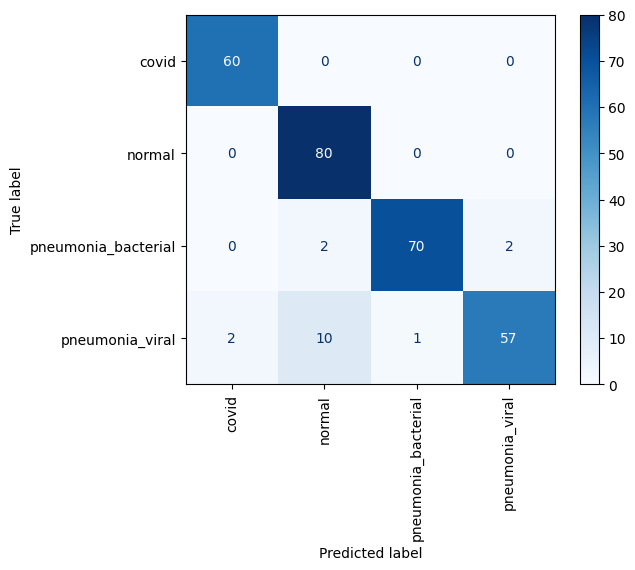

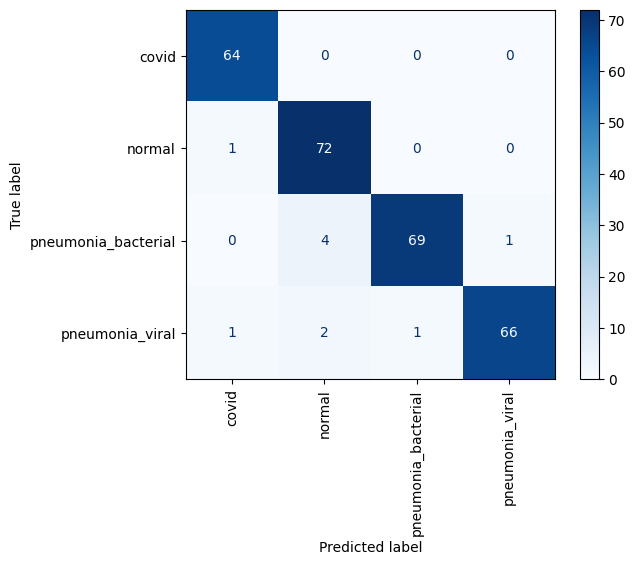

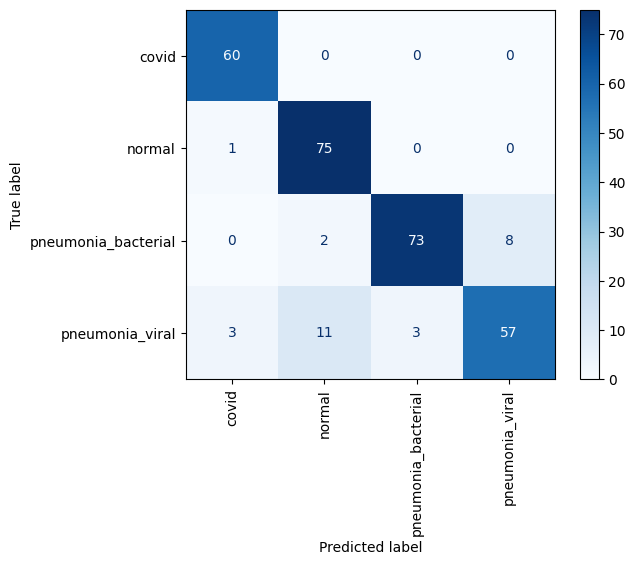

In [24]:
for fold in range(1, 6):
    fold_cm = evaluate_fold(fold)
    #fold_cm.figure_.savefig(f"confusion_matrix_{str(fold)}.png")

1/1 [==============================] - 0s 363ms/step
[[0.00174471 0.9753686  0.01502629 0.00786039]]


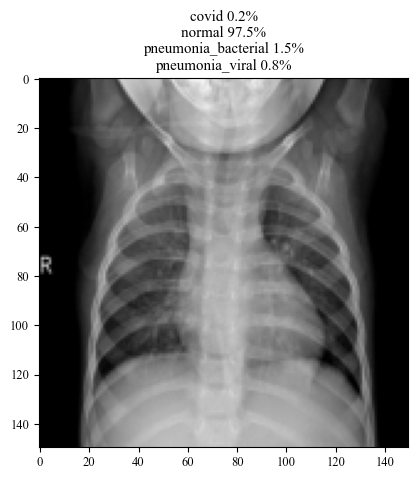

In [25]:
import cv2
from skimage import transform

img_r = cv2.imread('COVID-19_Radiography_Dataset/Normal/images/Normal-1001.png')


img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))

img = np.expand_dims(img2, axis=0)

r=model.predict(img)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
print(scores)

font = {
'family': 'Times New Roman',
'size': 9,

}
plt.rc('font', **font)

plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2)
#plt.savefig("normal_example.png")

1/1 [==============================] - 0s 16ms/step
[[3.4905731e-06 5.1566988e-04 9.8876476e-01 1.0715991e-02]]


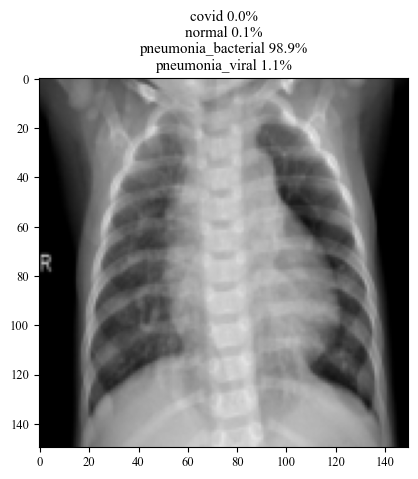

In [26]:
img_r = cv2.imread('covid-19/combined_folds/pneumonia_bacterial/person36_bacteria_185.jpeg')


img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))

img = np.expand_dims(img2, axis=0)

r=model.predict(img)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
print(scores)

font = {
'family': 'Times New Roman',
'size': 9,

}
plt.rc('font', **font)

plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2)

1/1 [==============================] - 0s 15ms/step
[[8.0217497e-04 6.3587479e-02 8.7344199e-02 8.4826618e-01]]


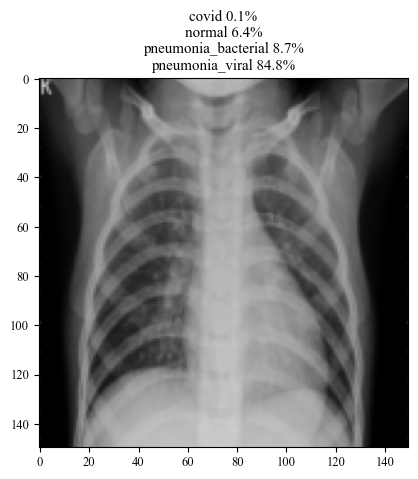

In [27]:
img_r = cv2.imread('covid-19/combined_folds/pneumonia_viral/person397_virus_790.jpeg')


img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))

img = np.expand_dims(img2, axis=0)

r=model.predict(img)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
print(scores)

font = {
'family': 'Times New Roman',
'size': 9,

}
plt.rc('font', **font)

plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")

plt.imshow(img2)